In [ ]:
## This is a series of examples using the icanswim/cosmosis data science and machine learning repo

In [1]:
from model import FFNet, tv_model
from learning import Learn, Selector, Metrics
from dataset import CDataset, SKDS, TVDS
from dataset import ImageDatasetStats, AsTensor, Squeeze, DType

from torch.optim import Adam
from torch.nn import MSELoss, CrossEntropyLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms

In [2]:
#example cosmosis dataset (CDataset)
import numpy as np

class ExampleDataset(CDataset):

    def load_data(self, boom='bust'):
        
        datadic = {1: {'feature_1': np.asarray([.04]),
                       'feature_2': np.asarray([.02]),
                       'feature_3': np.asarray(['z1']),
                       'feature_4': np.asarray(['c','c','d']),
                       'feature_5': np.asarray([1.1])},
                   2: {'feature_1': np.asarray([.03]),
                       'feature_2': np.asarray([.01]),
                       'feature_3': np.asarray(['x1','z1','y1']),
                       'feature_4': np.asarray(['d','a','d']),
                       'feature_5': np.asarray([1.2])}}
        
        self.embed_lookup = {'feature_4': {'a': 1,'b': 2,'c': 3,'d': 4, '0': 0},
                             'feature_3': {'z1': 1, 'y1': 2, 'x1': 3, '0': 0}}
        
        print(boom)
        return datadic
    
class ExampleTransform():
    def __call__(self, arr):
        return np.add(arr, 2)
    
class ExampleTransformTwo():
    def __call__(self, arr):
        return np.multiply(arr, .1)
    
ds_params = {'train_params': {'input_dict': {'model_input': {'X1': ['feature_1','feature_5'],
                                                             'X2': ['feature_5'],
                                                             'embed': ['feature_3']},
                                             'criterion_input': {'target': ['feature_2'],
                                                                 'embed': ['feature_4']}},
                              'transform': [ExampleTransform(), ExampleTransformTwo()],
                              'target_transform': [ExampleTransform()],
                              'pad': (5,),
                              'pad_feats': ['feature_5','feature_4'],
                              'boom': 'bang'}}
    
d = ExampleDataset(**ds_params['train_params'])
d[2]

bang
CDataset created...


{'model_input': {'X1': tensor([0.2030, 0.3200, 0.2000, 0.2000, 0.2000, 0.2000], dtype=torch.float64),
  'X2': tensor([0.3200, 0.2000, 0.2000, 0.2000, 0.2000], dtype=torch.float64),
  'embed': [array([3, 1, 2])]},
 'criterion_input': {'target': tensor([2.0100], dtype=torch.float64),
  'embed': [array([4, 1, 4, 0, 0])]}}

In [3]:
#example cosmosis sklearn regression dataset wrapper SKDS
ds_params = {'train_params': {'input_dict': {'model_input': {'features': ['X']},
                                             'criterion_input': {'target': ['y']}},
                              'dataset': 'make_regression',
                              'sk_params': {'n_samples': 100,
                                            'n_features': 5},
                              'features_dtype': 'float32',
                              'targets_dtype': 'float32'}}

sk = SKDS(**ds_params['train_params'])

sk[1]

creating scikit learn make_regression dataset...
CDataset created...


{'model_input': {'features': tensor([ 1.3699, -0.3390,  0.2879,  1.2063, -0.3773])},
 'criterion_input': {'target': tensor([126.1575])}}

In [4]:
#example cosmosis sklearn classification dataset wrapper (SKDS)
ds_params = {'train_params': {'input_dict': {'model_input': {'features': ['X']},
                                             'criterion_input': {'target': ['y']}},
                              'dataset': 'make_classification',
                              'features_dtype': 'float32',
                              'targets_dtype': 'int64',
                              'sk_params': {'n_samples': 100,
                                            'n_features': 10,
                                            'n_informative': 8,
                                            'n_clusters_per_class': 2,
                                            'flip_y': 0.05,
                                            'class_sep': 0.01,
                                            'n_classes': 4}}}

sk = SKDS(**ds_params['train_params'])

sk[1]

creating scikit learn make_classification dataset...
CDataset created...


{'model_input': {'features': tensor([-1.5656,  2.2287,  2.0883,  0.1914,  1.7528,  2.3342, -1.1792,  1.3067,
          -1.2795, -2.5435])},
 'criterion_input': {'target': tensor([0])}}

In [5]:
#example cosmosis torchvision image dataset wrapper (TVDS)
ds_params={'dataset': 'MNIST',
           'input_dict': {'model_input': {'features': ['images'],},
                          'criterion_input': {'target': ['labels']}},
           'tv_params': {'root': './data/',
                         'train': True,
                         'download': True,
                         'transform': transforms.Compose([
                                           transforms.Resize(224)]),
                         'target_transform': None}}

tvds = TVDS(**ds_params)
tvds[1]

creating torch vision MNIST dataset...
CDataset created...


{'model_input': {'image': <PIL.Image.Image image mode=L size=224x224 at 0x7F6A58FA1C10>},
 'criterion_input': {'target': 0}}

In [6]:
#example cosmosis torchvision image dataset wrapper (TVDS) with transforms and PIL stats
ds_params={'dataset': 'MNIST',
           'tv_params': {'root': './data/',
                         'train': True,
                         'download': True,
                         'transform': transforms.Compose([
                                           transforms.Resize(224)]),
                         'target_transform': None}}

tvds = TVDS(**ds_params)
ids = ImageDatasetStats(tvds)

print('mean: ', ids.stats.mean)
print('stddev: ', ids.stats.stddev)

#mean: 33.3/255 = .13
#stddev: 73.7/255 = .29

creating torch vision MNIST dataset...
CDataset created...
images to process: 60000
images processed: 10000
images processed: 20000
images processed: 30000
images processed: 40000
images processed: 50000
images processed: 60000
mean: [33.33091590401786], stddev: [73.70246726596685]
mean:  [33.33091590401786]
stddev:  [73.70246726596685]


creating scikit learn make_regression dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:02.697409
epoch: 0, lr: 0.01
train loss: 527560.870949074, val loss: 328648.1960227273
learning time: 0:00:10.132510
epoch: 10, lr: 0.005
train loss: 7658.051793981482, val loss: 9160.200017755682
test loss: 6907.841197620739
learning time: 0:00:17.085175


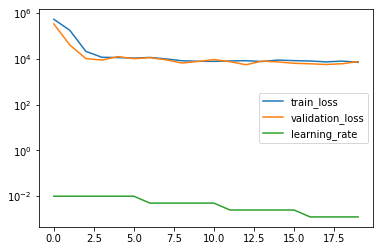

In [7]:
#example cosmosis sklearn regression dataset wrapper (SKDS) with sklearn metrics (Metrics) and 
#custom model (FFNet)
model_params = {'in_channels': 256, 
                'hidden': 512, 
                'out_channels': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['X']},
                                             'criterion_input': {'target': ['y']}},
                              'features_dtype': 'float32',
                              'targets_dtype': 'float32',
                              'dataset': 'make_regression',
                              'as_tensor': True,
                              'transform': [],
                              'sk_params': {'n_samples':20000,
                                            'n_features': 256,
                                            'n_informative': 200}}}
             
metrics_params = {'report_interval': 10,
                  'log_plot': True}                         
             
opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 2}

l = Learn([SKDS], 
          FFNet,
          Metrics=Metrics,
          Sampler=Selector, 
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=MSELoss,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params, 
          batch_size=256, epochs=20, gpu=True)

creating scikit learn make_classification dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:04.705939
epoch: 0, lr: 0.01
train loss: 0.010558617971632834, val loss: 0.009975495644741587
sklearn train metric: 0.5890006035069725, sklearn validation metric: 0.6614529648324287
learning time: 0:00:18.401877
epoch: 3, lr: 0.01
train loss: 0.006507478518779953, val loss: 0.006377266489096686
sklearn train metric: 0.8703194017991482, sklearn validation metric: 0.8804273954730837
learning time: 0:00:32.260970
epoch: 6, lr: 0.01
train loss: 0.004113391834915012, val loss: 0.00441071487023917
sklearn train metric: 0.9480200123867037, sklearn validation metric: 0.9416069100433199
learning time: 0:00:46.211731
epoch: 9, lr: 0.01
train loss: 0.00335850464325098, val loss: 0.003946363326942182
sklearn train metric: 0.9617285988514757, sklearn validation metric: 0.9502814376620732
test loss: 0.0038314519696829156
learning time: 0:00:46.82

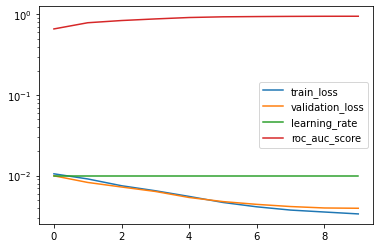

In [8]:
#example cosmosis sklearn classification dataset wrapper (SKDS) with sklearn metrics (Metrics) and 
#custom model (FFNet)
model_params = {'in_channels': 256, 
                'hidden': 128, 
                'out_channels': 4, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['X']},
                                             'criterion_input': {'target': ['y']}},
                              'features_dtype': 'float32',
                              'targets_dtype': 'int64',
                              'dataset': 'make_classification',
                              'sk_params': {'n_samples': 100000,
                                            'n_features': 300,
                                            'n_informative': 200,
                                            'n_clusters_per_class': 3,
                                            'flip_y': 0.05,
                                            'class_sep': 0.1,
                                            'n_classes': 4}}}
                                     
metrics_params = {'report_interval': 10,
                  'log_plot': True,
                  'sk_metric_name': 'roc_auc_score',
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 5}

l = Learn([SKDS], 
          FFNet, 
          Sampler=Selector,
          Metrics=Metrics,
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=CrossEntropyLoss,
          model_params=model_params, ds_params=ds_params, 
          sample_params=sample_params, opt_params=opt_params, 
          sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=(300,256,.2), batch_size=128, epochs=10, squeeze_y=True, save_model=True)

In [9]:
#example inference with cosmosis sklearn classification dataset wrapper (SKDS) and custom model (FFNet)
model_params = {'in_channels': 256, 
                'hidden': 128, 
                'out_channels': 4, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['X']},
                                             'criterion_input': {'target': ['y']}},
                              'features_dtype': 'float32',
                              'targets_dtype': 'int64',
                              'dataset': 'make_classification',
                              'sk_params': {'n_samples': 10000,
                                            'n_features': 300,
                                            'n_informative': 200,
                                            'n_clusters_per_class': 3,
                                            'flip_y': 0.05,
                                            'class_sep': 0.1,
                                            'n_classes': 4}}}
                                     
metrics_params = {'report_interval': 10, 
                  'sk_metric_name': 'roc_auc_score',
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 5}

l = Learn([SKDS], 
          FFNet, 
          Sampler=Selector,
          Metrics=Metrics,
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=None,
          model_params=model_params, ds_params=ds_params, 
          sample_params=sample_params, opt_params=opt_params, 
          sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=128, epochs=1, squeeze_y=True, load_model='20221025_1522.pth')

creating scikit learn make_classification dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
model loaded from pickle...
running model on gpu...
inference 2023-03-02 13:35:00.965909 complete and saved to csv...


creating torch vision CIFAR10 dataset...
Files already downloaded and verified
CDataset created...
creating torch vision CIFAR10 dataset...
Files already downloaded and verified
CDataset created...
torchvision model resnet18 loaded...
running model on gpu...
learning time: 0:00:04.825568
epoch: 0, lr: 0.01
train loss: 2.327541477680206, val loss: 2.032648471093947
sklearn train metric: 0.6419723784113052, sklearn validation metric: 0.7287387777083117
learning time: 0:00:19.075417
epoch: 3, lr: 0.01
train loss: 1.7456743302345277, val loss: 1.7270527731987737
sklearn train metric: 0.8116353959758034, sklearn validation metric: 0.8258778291590714
test loss: 1.7444382564544678
learning time: 0:00:22.701391
sklearn test metric: 
0.8211114777777778 



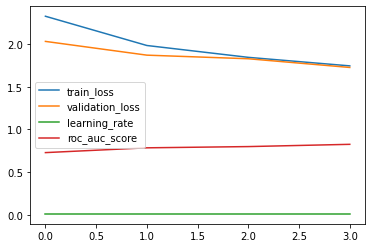

In [10]:
#example cosmosis torchvision image dataset wrapper(TVDS),transforms (transforms) and 
#torchvision model wrapper (tv_model)
model_params = {'model_name': 'resnet18',
                'in_channels': 3,
                'tv_params': {'num_classes': 10}}

ds_params={'train_params': {'dataset': 'CIFAR10',
                            'tv_params': {'root': './data/',
                                          'train': True,
                                          'download': True,
                                          'transform': transforms.Compose([
                                                           transforms.RandomRotation(10),
                                                           transforms.Resize(64),
                                                           transforms.ToTensor()]),
                                          'target_transform': None,
                                          'download': True}},
           'test_params': {'dataset': 'CIFAR10',
                           'tv_params': {'root': './data/',
                                         'train': False,
                                         'download': True,
                                         'transform': transforms.Compose([
                                                         transforms.Resize(64),
                                                         transforms.ToTensor()]),
                                         'target_transform': None,
                                         'download': True}}}

metrics_params = {'report_interval': 10, 
                  'sk_metric_name': 'roc_auc_score', 
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.8,),
                 'subset': .1}

sched_params = {'factor': .5,
                'patience': 1,
                'cooldown': 1}

l = Learn([TVDS,TVDS], 
          tv_model, 
          Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=CrossEntropyLoss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params, 
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params, 
          batch_size=16, epochs=4)

creating torch vision CIFAR10 dataset...
CDataset created...
creating torch vision CIFAR10 dataset...
CDataset created...
torchvision model resnext50_32x4d loaded...
running model on gpu...
learning time: 0:01:01.351821
epoch: 0, lr: 0.01
train loss: 2.721245726108551, val loss: 2.099176949070346
sklearn train metric: 0.5785657235795008, sklearn validation metric: 0.7007819256028653
learning time: 0:02:02.699027
epoch: 1, lr: 0.01
train loss: 2.0750389900207518, val loss: 2.0562457499965543
sklearn train metric: 0.6975045916806974, sklearn validation metric: 0.7326908548573025
learning time: 0:03:04.103863
epoch: 2, lr: 0.01
train loss: 1.9925228810310365, val loss: 1.9411281212683646
sklearn train metric: 0.735864540016313, sklearn validation metric: 0.7592732695921663
learning time: 0:04:06.575523
epoch: 3, lr: 0.01
train loss: 1.9306351714134216, val loss: 1.8809791726450766
sklearn train metric: 0.7554215510315041, sklearn validation metric: 0.7825782954792864
test loss: 1.88460103

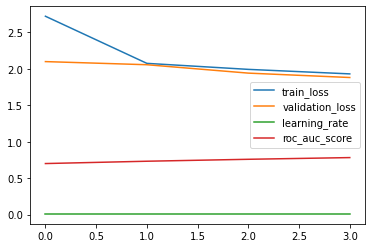

In [11]:
#example cosmosis torchvision dataset wrapper (TVDS) and torchvision model wrapper (tv_model)
model_params = {'model_name': 'resnext50_32x4d',
                'in_channels': 3,
                'tv_params': {'num_classes': 10}}

ds_params={'train_params': {'dataset': 'CIFAR10',
                            'tv_params': {'root': './data/',
                                          'train': True,
                                          'transform': transforms.Compose([
                                                       transforms.RandomRotation(10),
                                                       transforms.Resize(256),
                                                       transforms.ToTensor()]),
                                          'target_transform': None}},
           'test_params': {'dataset': 'CIFAR10',
                           'tv_params': {'root': './data/',
                                         'train': False,
                                         'transform': transforms.Compose([
                                                      transforms.Resize(256),
                                                      transforms.ToTensor()]),
                                         'target_transform': None}}}

metrics_params = {'report_interval': 10, 
                  'sk_metric_name': 'roc_auc_score', 
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.8,),
                 'subset': .1}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 2}

l = Learn([TVDS,TVDS], 
          tv_model, 
          Selector, 
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=CrossEntropyLoss, 
          model_params=model_params, ds_params=ds_params, 
          sample_params=sample_params, opt_params=opt_params, 
          sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=16, epochs=4)